<a href="https://colab.research.google.com/github/aimalz/galevo23-tutorials/blob/main/week-4/KITPCCA_photo_z_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Photo-$z$s: A tutorial</center>
#### <center> **[Alex I. Malz](https://github.com/aimalz)**</center>
#### <center> LINCC Frameworks @ Carnegie Mellon University </center>
#### <center>  </center>
#### <center> [KITP-CCA Workshop: Data Driven Galaxy Evolution](https://datadrivengalaxyevolution.github.io/#ccaweek) </center>

This tutorial was adapted from [a problem set](https://github.com/LSSTC-DSFP/LSSTC-DSFP-Sessions/blob/main/Sessions/Session16/Day4/expdes-photoz.ipynb) at the [LSSTC Data Science Fellowship Program](https://astrodatascience.org/), which was in turn adapted from a data challenge at a workshop;
if you use anything from here in a publication, cite [the repo it originally came from](https://github.com/aimalz/qtc2021) and acknowledge "[From Quarks to Cosmos with AI](https://events.mcs.cmu.edu/qtc2021/), a conference supported by the NSF AI Institute: Physics of the Future, NSF PHY-2020295." 

## Overview

As we look ahead to inferring the physics of galaxy evolution from deep catalogs lacking spectroscopy, we will very likely need to rely on photometric redshifts (photo-$z$s) for large-scale analyses.
This tutorial assumes you know the basic idea and have some familiarity with how redshift estimates factor into the kinds of analyses you want to do.
My goal is to impart an appreciation for the nuances of photo-$z$s we have to anticipate for LSST data to help us all get the most out of them.

This notebook provides some choices of photo-$z$ estimation models, options for data and priors upon which to test the models, and a variety of metrics to evaluate the estimates, an end-to-end pipeline for 
Your objective is to uncover the unstated assumptions, probe the limiting cases, and overall figure out how to break the experiment, thereby identifying what you need to do to ensure photo-$z$ data products suit your needs.

## Motivation

More and more machine learning (ML) methods, particularly in Bayesian deep learning, yield uncertainties $\hat{p}(y | x_{i})$ of target parameters $y$ given observed random variables $x_{i}$, rather than just point estimates $\hat{y}_{i}$.
Though rarely framed as such, these uncertainties are _posteriors_, and there's more than meets the eye to what lies on the righthand side of the conditional.

Really, an estimated posterior should be writen as $p(y | x_{i}, \pi, M)$ for prior $\pi$ (which is training data $\{y_{n}, x_{n}\}_{N}$ for a machine learning approach and takes other forms for physics-informed models) and algorithm (model) $M$.
Though the dependence on prior information is straightforward, the dependence on the algorithm, meaning the estimation model and its implementation, is subtle.
However, if it were not there, then every model with the same prior information would yield identical estimated uncertainties, which is not observed.
While the $\pi$ (e.g. training set $\{y_{n}, x_{n}\}_{N}$) is equivalent to an _explicit prior_, the algorithm $M$ must be considered an _implicit prior_, in that we don't know how to write down how it projects onto the space of data.

Another way of looking at estimated posteriors is in terms of the type of uncertainty encompassed by each term on the righthand side of the conditional.
For a noisy measurement or a stochastic generative process, the random variable $x_{i} \sim p(x | y_{i})$ represents the _aleatoric uncertainty_, the uncertainty inherent to the data.
However, the training set $\{y_{n}, x_{n}\}_{N}$ and implemented etimation model $M$ could potentially be improved to yield a better estimate and thus constitute sources of _epistemic uncertainty_, the uncertainty due to an imperfect model.
In physics, we want to learn the aleatoric uncertainty $p(x | y_{i})$, which we can't get from the estimated posteriors $p(y | x_{i}, \{y_{n}, x_{n}\}_{N}, M)$ in hand without knowing $p(y | \{y_{n}, x_{n}\}_{N}, M)$.

Meanwhile, assessments of the performance of estimated $p(y | x_{i}, \{y_{n}, x_{n}\}_{N}, M)$ are almost always made by comparison to known $y_{i}$, leaving unanswered the question of how well the estimator approximates $p(y | x_{i})$.
Why?
The problem is that $p(y | x_{i})$ is not necessarily known, certainly not for observed $y_{i}$ measured in nature, but also generally for simulated $y_{i}$, at least in astrophysics.
To avoid the pitfalls of the LSST-DESC PZ DC1 experiment, we want to have those true posteriors, so we have to design an experiment that makes those accessible.

## Context: Photometric redshifts

[Photo-$z$s](https://en.wikipedia.org/wiki/Photometric_redshift) provide an excellent testbed for addressing these issues but require some introduction.
There isn't a definitive primer, but here are several overviews that are informative, if a bit dry.
- [basic intro from Rubin Observatory](https://www.lsst.org/science/dark-energy/photometric-redshift)
- [old overview covering classic concepts](https://ned.ipac.caltech.edu/level5/Glossary/Essay_photredshifts.html)
- [recent review of estimation methods](https://arxiv.org/abs/1805.12574)
If these don't answer your questions, Chapter 0 of [my thesis](https://zenodo.org/record/3973536) might, or, better yet, [the slides from my defense](https://github.com/aimalz/ship-of-theses/tree/master/presentation) make for a better tl;dr.

One reason photo-$z$s are perfect for a data challenge is that they are simple enough to obtain $p(y | x_{i})$ along the way to generating a sample of $(y_{i}, x_{i})$ pairs.
Here, the target variable $y \to z$ is redshift, a scalar, and the data $x \to \vec{d} = (u, g, r, i, z, y)$, or some trivial function thereof, is a vector of length $<10$ observed [photometric magnitudes](https://en.wikipedia.org/wiki/Magnitude_(astronomy)) of galaxies through [broadband optical filters](https://en.wikipedia.org/wiki/Photometric_system) (which I somewhat arbitrarily choose to be those of [the Vera C. Rubin Observatory](https://www.lsst.org/)).
Because of the extremely low dimensionality of the problem, we can forward model not just individual pairs $(z_{i}, \vec{d}_{i})$ but the entire joint probability space $p(z, \vec{d})$, thereby obtaining $p(y | x_{i})$ for every $(z_{i}, \vec{d}_{i})$.
That doesn't mean it's trivial to do so -- most of this tutorial concerns that forward-modeling procedure -- but it is possible.

Another reason photo-$z$s are perfect for this data challenge is that comprehensive uncertainty quantification for galaxy redshifts in the absence of spectroscopy are crucial for the Legacy Survey of Space and Time (LSST), an upcoming photometric survey on the Rubin Observatory.
This data challenge has the ulterior motive of strengthening the cosmology analysis pipeline of LSST's Dark Energy Science Collaboration (DESC).
This tutorial makes use of two pieces of software DESC members are publicly developing right now, [RAIL](https://github.com/LSSTDESC/RAIL) and [qp](https://github.com/LSSTDESC/qp), whose functionality will be introduced where relevant, along with other code dependencies.
Participants need not use either in their responses to the challenge questions, but the development team welcomes feedback from potential users, contributions to the codebase that could result from this data challenge, and new team members, DESC membership not required.

# Tutorial and challenge prompts

Finally, without more ado, we set the stage with a tutorial that:
1. creates realistically complex mock photo-$z$ posteriors, redshifts, and photometry to define training and test sets;
2. estimates photo-$z$ posteriors of the test set given the training set using ML;
3. quantifies how closely the estimated posteriors approximate the true ones.

_The three-pronged structure of this tutorial is inspired by that of RAIL, which has subpackages corresponding to each of the enumerated parts of the tutorial: `rail.creation`, `rail.estimation`, and `rail.evaluation`._

The challenge comes from building on the tutorial content to conduct a self-guided investigation of the open questions.
To get the most out of this opportunity, think of this tutorial as a lab manual that presents an experimental procedure to answer each question and includes an example of a possible solution, then invites participants to "riff" on those solutions to devise and implement their own.
The greatest opportunities for such investigations can be found under the headings **"Your turn!"** throughout the tutorial, but there are certainly more interesting directions to go in.

## 0. Setup

In [1]:
!pip install scikit-learn scipy==1.10.0 corner
!pip install cde-diagnostics cdetools FlexCode xgboost==0.90
!pip install pz-rail

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 24.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for FlexCode: filename=flexcode-0.1.5-py3-none-any.whl size=8353 sha256=594be78f65003f4ea96cab3738c7fef05caa2cfd2aa075944a4849a80b852818
  Stored in directory: /root/.cache/pip/wheels/d1/fc/f6/a87e1e91023d26981196e0f69240e9848b777fb38a01a35326
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=d4138c67bf507c4b664fec49801cd71dee2330905a7d5ae4103708888e6eb8b6
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e7514

In [2]:
import jax.numpy as jnp
import numpy as np
import pandas as pd
import sklearn

In [3]:
import cdetools
import flexcode
import pzflow
import qp

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpl_patches
mpl.rc('text', usetex=False)

import corner

## 1. Generating mock data, including true photo-$z$ posteriors

This is the most complex of the parts of the tutorial, which should leave readers with a sense of why this kind of experiment has not been done for higher-dimensional data.
There are three main steps:
1. Prepare and explore data to use as the basis for a realistically complex generative model.
2. Emulate a few realistically complex $p(z, \vec{d})$ probability spaces using input data.
3. Sample $p(z, \vec{d})$ and $p'(z, \vec{d})$ to produce photometric data sets to use as explicit prior information and on which to estimate redshift posteriors, with known $z$, $\vec{d}$, and $p(z | \vec{d})$.

### Data

Though we're going to forward-model mock data to experiment on, we want it to be _realistically complex_, meaning it shares the physical degeneracies and systematic errors that would be present in a real data set.
The [Happy/Teddy data sets](https://github.com/COINtoolbox/photoz_catalogues) (see [Beck, et al 2017](https://arxiv.org/abs/1701.08748) for full release notes) are curated subsamples of the [Sloan Digital Sky Survey (SDSS) Data Release (DR) 12](https://www.sdss.org/dr12/), a spectroscopic survey with high-fidelity redshift measurements, and were created by the [Cosmostatistics Initiative (COIN)](https://cosmostatistics-initiative.org/).
The data sets are defined to emulate the kinds of differences in observational properties of galaxies with measured spectroscopic redshifts and those for which only photometry is available, and they were created with the goal of determining the impact of imbalance between training, validation, and test sets for photo-$z$ point estimation.
They are thus an appropriate starting point for creating a realistically complex model of the joint probability space $p(z, \vec{d})$.

Of course there are plenty of other potential data sets available, including those that are simulated, which may be advantageous for the potential to estimate other galaxy properties such as stellar mass and star formation rate that are known in a simulation but not directly measurable with real data.

In [5]:
!git clone https://github.com/COINtoolbox/photoz_catalogues.git

Cloning into 'photoz_catalogues'...
remote: Enumerating objects: 220, done.
remote: Total 220 (delta 0), reused 0 (delta 0), pack-reused 220
Receiving objects: 100% (220/220), 74.77 MiB | 11.17 MiB/s, done.
Resolving deltas: 100% (118/118), done.
Updating files: 100% (31/31), done.


In [6]:
happy_path = './photoz_catalogues/Happy/happy_'
header = pd.read_csv(happy_path+'A', delim_whitespace=True, nrows=0).columns[1:]
teddy_path = './photoz_catalogues/Teddy/teddy_'

happy, teddy = {}, {}
for lett in ['A', 'B', 'C', 'D']:
    happy[lett] = pd.read_csv(happy_path+lett, delim_whitespace=True, header=None, skiprows=1, names=header)
    happy[lett] = happy[lett].rename(columns={'z_spec':'redshift', 'mag_r': 'r'})[['redshift', 'r', 'u-g', 'g-r', 'r-i', 'i-z']]
#     happy[lett]
    teddy[lett] = pd.read_csv(teddy_path+lett, delim_whitespace=True, header=None, skiprows=7, names=header)
    teddy[lett] = teddy[lett].rename(columns={'z_spec':'redshift', 'mag_r': 'r'})[['redshift', 'r', 'u-g', 'g-r', 'r-i', 'i-z']]
#     teddy[lett]

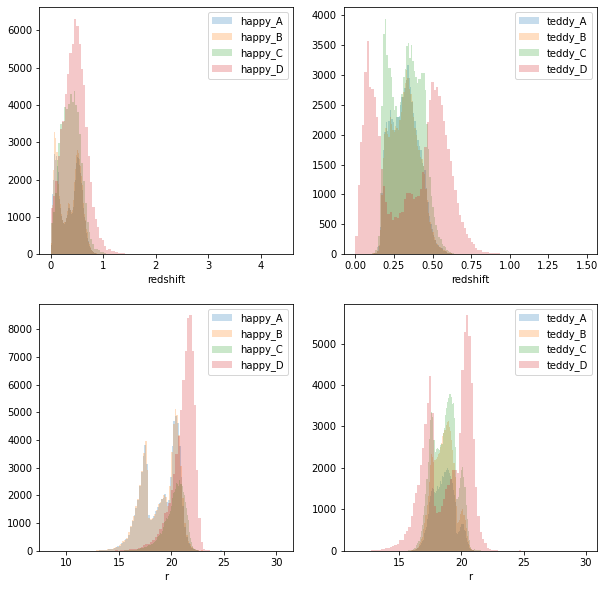

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for j, col in enumerate(['redshift', 'r']):
    for i, lett in enumerate(['A', 'B', 'C', 'D']):
        ax[j][0].hist(happy[lett][col], alpha=0.25, bins=100, density=False, label='happy_'+lett)
        ax[j][1].hist(teddy[lett][col], alpha=0.25, bins=100, density=False, label='teddy_'+lett)
        ax[j][0].set_xlabel(col)
        ax[j][0].legend()
        ax[j][1].set_xlabel(col)
        ax[j][1].legend()

For convenience later on, we can safely cut off the tiny fraction of outliers in redshift and $r$-band magnitude.

In [8]:
z_min, z_max = 0., 1.5
r_min, r_max = 10., 25.

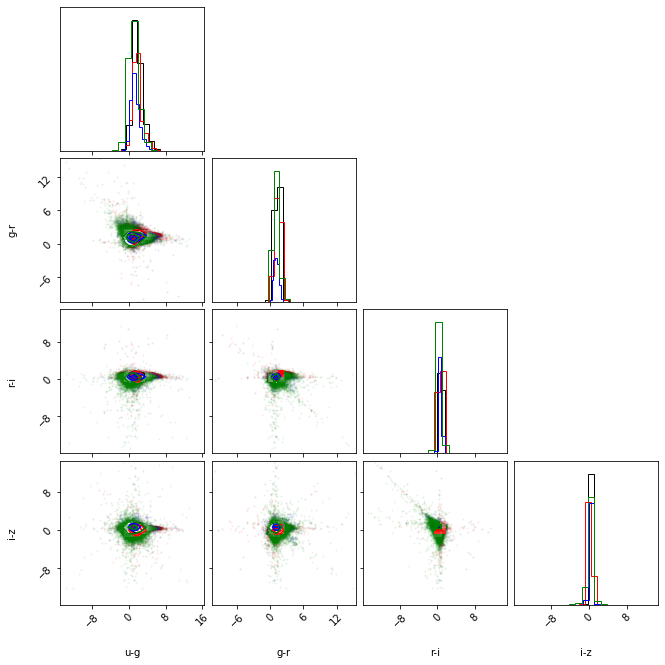

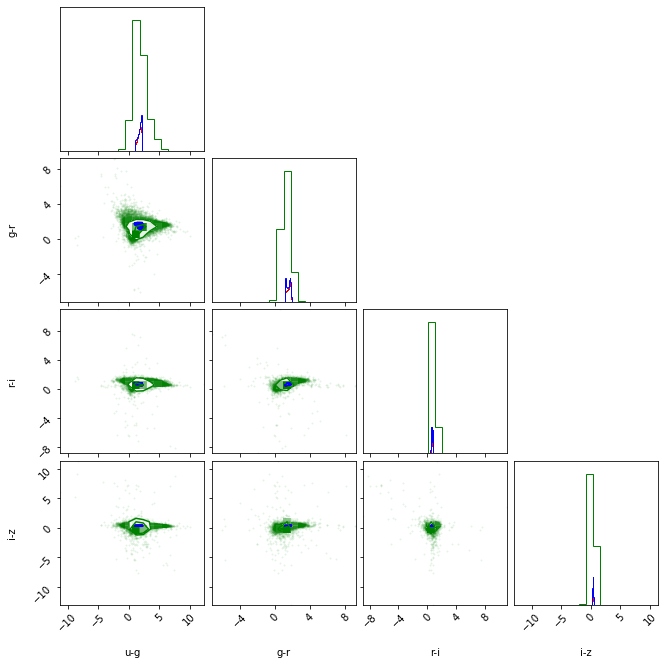

In [9]:
colorcycle = 'rbgcmy'
fig = corner.corner(happy['A'][['u-g', 'g-r', 'r-i', 'i-z']], color='k', alpha=0.25)
for i, lett in enumerate(['B', 'C', 'D']):
    corner.corner(happy[lett][['u-g', 'g-r', 'r-i', 'i-z']], fig=fig, color=colorcycle[i], alpha=0.25)
    
fig = corner.corner(teddy['A'][['u-g', 'g-r', 'r-i', 'i-z']], color='k', alpha=0.25)
for i, lett in enumerate(['B', 'C', 'D']):
    corner.corner(teddy[lett][['u-g', 'g-r', 'r-i', 'i-z']], fig=fig, color=colorcycle[i], alpha=0.25)

### Emulating $p(z, \vec{d})$ from input data

[`pzflow`](https://github.com/jfcrenshaw/pzflow) is a package for making normalizing flows from sets of redshifts and photometry in order to estimate or otherwise model photo-$z$ posteriors.
We'll use it to make a normalizing flow that will serve as the model for $p(z, \vec{d})$.

_This content is adapted from pzflow's [demo](https://github.com/jfcrenshaw/pzflow/blob/main/docs/tutorials/intro.ipynb), written by John Franklin Crenshaw (UW)._

In [10]:
from pzflow import Flow
from pzflow.bijectors import Chain, ColorTransform, InvSoftplus, StandardScaler, RollingSplineCoupling, ShiftBounds
from pzflow.examples import get_galaxy_data
from pzflow.distributions import Uniform

Let's start with a demonstration of how pzflow makes a model of $p(z, \vec{d})$ from its own demo data.

In [11]:
data = get_galaxy_data()

In [12]:
data = get_galaxy_data()

# restrict to Happy/Teddy range for coverage in demo
data = data[(data['redshift'] > z_min) & (data['redshift'] < z_max) & (data['r'] > r_min) & (data['r'] < r_max)]

# normalize
data = data

# use fewer bands to be able to compare with Happy/Teddy
data = data[['redshift', 'u', 'g', 'r', 'i', 'z']]

# convert magnitudes to a reference magnitude and colors
data['u-g'] = data['u'] - data['g']
data['g-r'] = data['g'] - data['r']
data['r-i'] = data['r'] - data['i']
data['i-z'] = data['i'] - data['z']

# save the new set
data = data[['redshift', 'r', 'u-g', 'g-r', 'r-i', 'i-z']]

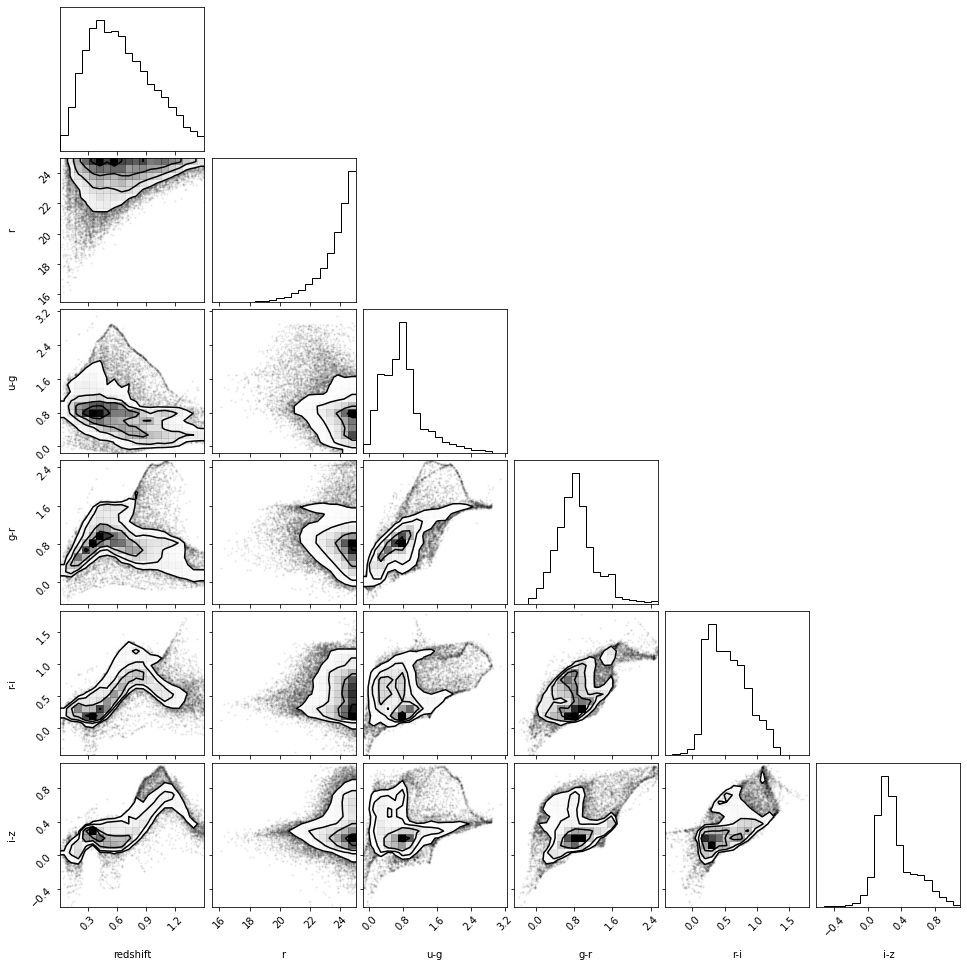

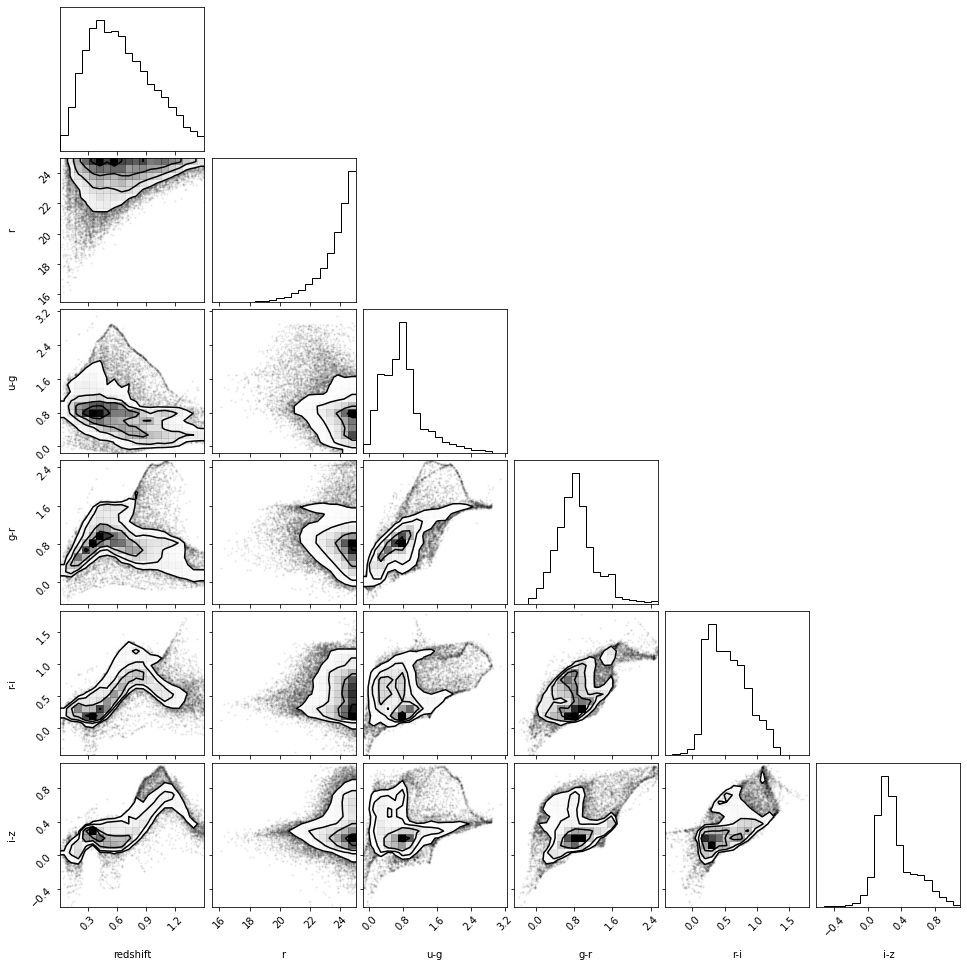

In [13]:
corner.corner(data)

In [14]:
# set the inverse softplus parameters, estimated
# to ensure that sampled redshifts are positive
column_idx = 0

n_epoch = 30

mins = [z_min, r_min, -1, -1, -1, -1]
maxs = [z_max, r_max, 5, 5, 5, 5]

# construct our bijector
# by chaining all these layers
bijector = Chain(
    ShiftBounds(mins, maxs, B=5),
    RollingSplineCoupling(nlayers=6)
)


flow = Flow(data.columns, bijector)

This step may be slow (~minutes) if you don't have a GPU runtime enabled (or if jax can't find the Colab GPU?).

In [15]:
losses = flow.train(data, epochs=n_epoch, verbose=True)

Training 30 epochs 
Loss:
(0) 13.0925
(1) 2.7081
(2) 0.7363
(3) -0.4591
(4) -0.6606
(5) -1.6691
(6) -1.4062
(7) -1.5592
(8) -2.0852
(9) -2.0961
(10) -2.0141
(11) -2.2670
(12) -2.3668
(13) -2.5295
(14) -1.9649
(15) -2.3812
(16) -2.3642
(17) -2.5676
(18) -2.7107
(19) -2.7456
(20) -2.9323
(21) -2.5047
(22) -2.9983
(23) -2.7933
(24) -2.9696
(25) -2.7785
(26) -3.1116
(27) -3.0723
(28) -3.1517
(29) -2.4265
(30) -2.8933


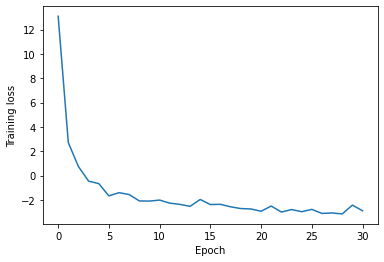

In [16]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.show()

In [17]:
flow.save('default_flow.pkl')
flow = Flow(file='default_flow.pkl')

We need to choose a redshift grid upon which to evaluate the posterior PDFs.

In [18]:
granularity = 100
grid = np.linspace(z_min, z_max, granularity)

Let's check one of them before making more.

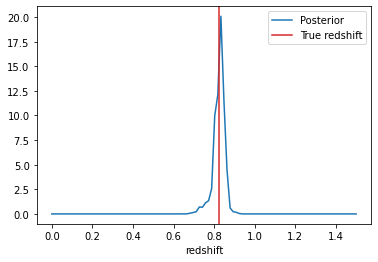

In [19]:
chosen = 999

galaxy = data.iloc[[chosen]]
pdf = flow.posterior(galaxy, column="redshift", grid=grid)

plt.plot(grid, pdf[0], label='Posterior')
plt.axvline(galaxy['redshift'].values[0], 0, 1, c='C3', label='True redshift')
plt.legend()
plt.xlabel("redshift")
plt.show()

Sample from the model of $p(z, data)$.
(If you run out of memory, take fewer samples.)

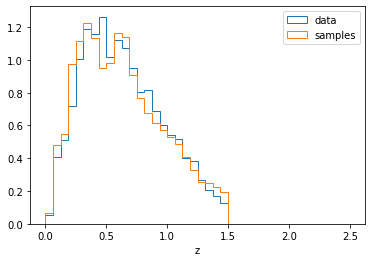

In [20]:
samples = flow.sample(10000, conditions=data[:5000], seed=0)
plt.hist(data['redshift'], range=(0, 2.5), bins=40, histtype='step', label='data', density=True)
plt.hist(samples['redshift'], range=(0, 2.5), bins=40, histtype='step', label='samples', density=True)
plt.xlabel('z')
plt.legend()
plt.show()

In [21]:
z = samples['redshift']
z.to_csv('test_set_redshifts.csv')

phot = samples[['r', 'u-g', 'g-r', 'r-i', 'i-z']]
phot.to_csv('test_set_photometry.csv')

posteriors = flow.posterior(samples, column="redshift", grid=grid)
with open('test_set_posteriors.csv', 'wb') as fn:
    jnp.save(fn, posteriors)

We can do this procedure for all the Happy/Teddy samples so we can experiment with them later.
It's slow without using GPU, but it only needs to be done once.

In [39]:
full_data = {'teddy': teddy}#'happy': happy
# not sure why Happy data sets won't train on colab now?
n_out = 1000

In [38]:
for name, dat in full_data.items():
    for lett in ['A', 'B', 'C':]#, 'D']:
      # also not sure why teddyD won't train anymore. . .
        print(name+lett)
        print(dat[lett].columns)
        print(len(dat[lett]))
        
        flow = Flow(dat[lett].columns, bijector)

        losses = flow.train(dat[lett], epochs=n_epoch, verbose=True)
        flow.save(name+lett+'flow.pkl')
        print('done with '+name+lett)

happyA
Index(['redshift', 'r', 'u-g', 'g-r', 'r-i', 'i-z'], dtype='object')
74950
Training 30 epochs 
Loss:
(0) inf
(1) inf
(2) inf
(3) inf
(4) inf
(5) inf
(6) inf
(7) inf
(8) inf
(9) inf
(10) inf
(11) inf
(12) inf
(13) inf
(14) inf
(15) inf
(16) inf
(17) inf
(18) inf
(19) inf
(20) inf
(21) inf
(22) inf
(23) inf
(24) inf
(25) inf
(26) inf
(27) inf
(28) inf
(29) inf
(30) inf
done with happyA
happyB
Index(['redshift', 'r', 'u-g', 'g-r', 'r-i', 'i-z'], dtype='object')
74900
Training 30 epochs 
Loss:
(0) inf
(1) inf
(2) inf
(3) inf
(4) inf
(5) inf
(6) inf
(7) inf
(8) inf
(9) inf
(10) inf
(11) inf
(12) inf
(13) inf
(14) inf
(15) inf
(16) inf
(17) inf
(18) inf
(19) inf
(20) inf
(21) inf
(22) inf
(23) inf
(24) inf
(25) inf
(26) inf
(27) inf
(28) inf
(29) inf
(30) inf
done with happyB
happyC
Index(['redshift', 'r', 'u-g', 'g-r', 'r-i', 'i-z'], dtype='object')
60315
Training 30 epochs 
Loss:
(0) inf
(1) inf
(2) inf
(3) inf
(4) inf
(5) inf
(6) inf
(7) inf
(8) inf
(9) inf
(10) inf
(11) inf
(12) i

In [40]:
for name, dat in full_data.items():
    for lett in ['A', 'B', 'C']:#, 'D']:     
        print(name+lett)
        flow = Flow(file=name+lett+'flow.pkl')

        samples = flow.sample(10000, conditions=dat[lett].sample(n_out), seed=0)

        z = samples['redshift']
        z.to_csv(name+lett+'redshifts.csv', index=False)

        phot = samples[['r', 'u-g', 'g-r', 'r-i', 'i-z']]
        phot.to_csv(name+lett+'photometry.csv', index=False)

        posteriors = flow.posterior(samples, column="redshift", grid=grid)
        with open(name+lett+'posteriors.csv', 'wb') as fn:
            jnp.save(fn, posteriors)

teddyA
teddyB
teddyC


### Challenge 1

Try to "degrade" the data to introduce degeneracies, inconsistencies, and nonrepresentativity that could trip up an estimator with or without being missed by a metric.
Show what that photometry looks like and save it to feed into estimators later in the tutorial.

## 2. Estimating photo-z posterior PDFs

There are many estimators of photo-$z$ posteriors, and many of those are compared to one another in [Schmidt & Malz, et al. 2020](https://arxiv.org/abs/2001.03621).
The outcomes of that experiment inspired the design of the [Redshift Assessment Infrastructure Layers (RAIL](https://github.com/LSSTDESC/RAIL) codebase, an open-source toolkit that provides a unified API for many photo-$z$ estimators and instructions for wrapping additional ones to be included.
If you need to obtain photo-$z$ PDFs at scale, the [Golden Spike](https://github.com/LSSTDESC/RAIL/tree/main/examples/goldenspike) end-to-end demo is a great starting point.
This repository also now has a Colab-ified version of the Golden Spike for your convenience.

### Estimating photo-$z$ posterior PDFs with FlexCode


Of the tested estimators in the aforementioned experiment, including ML and non-ML methods, the most promising was [`FlexCode`](https://github.com/tpospisi/FlexCode) ([Izbicki & Lee, 2017](https://arxiv.org/abs/1704.08095)), which also happens to be one of the easiest to install and apply as a standalone code, so we'll use it as an example of an estimator of photo-$z$ posteriors.

A demonstration of `FlexCode` in the context of photo-$z$s can be found in [Dalmasso, et al 2019](https://arxiv.org/abs/1908.11523), with demos in `R` published on [GitHub](https://github.com/Mr8ND/cdetools_applications).
We'll demonstrate it on the pzflow-based samples generated from the Happy/Teddy data sets.

_This content is adapted from FlexCode's [Teddy tutorial](https://github.com/tpospisi/FlexCode/blob/master/tutorial/Flexcode-tutorial-teddy.ipynb), written by Nic Dalmasso (CMU)._

In [24]:
n_grid = granularity

# Select regression method
from flexcode.regression_models import NN

# Parameters
basis_system = "cosine"  # Basis system
max_basis = 31           # Maximum number of basis. If the model is not tuned,
                         # max_basis is set as number of basis

n_estimators = 100
criterion = 'mse'
max_depth = 5
    
# Regression Parameters 
# If a list is passed for any parameter automatic 5-fold CV is used to
# determine the best parameter combination.
params = {"k": 20}#[5, 10, 15, 20]}       # A dictionary with method-specific regression parameters.

Let's try first with a representative training/validation set.

In [25]:
x_orig = pd.read_csv('test_set_photometry.csv')[['r', 'u-g', 'g-r', 'r-i', 'i-z']].to_numpy()
y_orig = pd.read_csv('test_set_redshifts.csv')[['redshift']].to_numpy()
posteriors_orig = pd.DataFrame(np.load('test_set_posteriors.csv')).to_numpy()

# n_samp = 10000
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test, posteriors_train, posteriors_test = train_test_split(x_orig, y_orig, posteriors_orig, 
                                                                                       train_size=2000, random_state=42)
x_train, x_validation, y_train, y_validation, posteriors_train, posteriors_validation = train_test_split(x_train, y_train, posteriors_train, 
                                                                                                         train_size=1000, random_state=42)

In [26]:
# Parameterize model
model = flexcode.FlexCodeModel(NN, max_basis, basis_system, regression_params=params)

# Fit model - this will also choose the optimal number of neighbors `k`
model.fit(x_train, y_train)

# Tune model - Select the best number of basis
model.tune(x_validation, y_validation)

# Predict new densities on grid
cde_test, y_grid = model.predict(x_test, n_grid=n_grid)

We can examine one of the photo-$z$ posteriors estimated with the perfectly representative training/validation set.

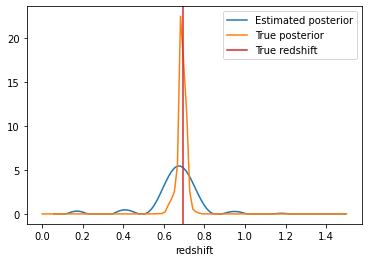

In [27]:
chosen = 9

plt.plot(y_grid, cde_test[chosen], label='Estimated posterior')
plt.plot(grid, posteriors_test[chosen], label='True posterior')
plt.axvline(y_test[chosen], 0, 1, c='C3', label='True redshift')
plt.legend()
plt.xlabel("redshift")
plt.show()

It looks pretty good!
Now let's try training and validating with some Happy/Teddy data but estimating posteriors on the test set from the pzflow demo.

In [41]:
y_train = pd.read_csv('teddyAredshifts.csv')['redshift'].to_numpy()
x_train = pd.read_csv('teddyAphotometry.csv')[['r', 'u-g', 'g-r', 'r-i', 'i-z']].to_numpy()

y_validation = pd.read_csv('teddyBredshifts.csv')['redshift'].to_numpy()
x_validation = pd.read_csv('teddyBphotometry.csv')[['r', 'u-g', 'g-r', 'r-i', 'i-z']].to_numpy()

# similar for TeddyC?

In [42]:
# Parameterize model
model = flexcode.FlexCodeModel(NN, max_basis, basis_system, regression_params=params)

# Fit model - this will also choose the optimal number of neighbors `k`
model.fit(x_train, y_train)

# # # Tune model - Select the best number of basis
model.tune(x_validation, y_validation)

# # Predict new densities on grid
cde_test_bias, y_grid_bias = model.predict(x_test, n_grid=n_grid)

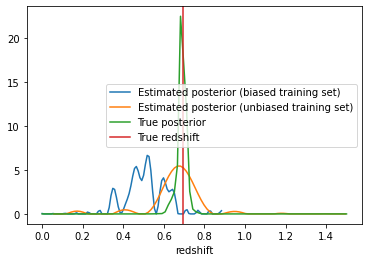

In [43]:
plt.plot(y_grid_bias, cde_test_bias[chosen], label='Estimated posterior (biased training set)')
plt.plot(y_grid, cde_test[chosen], label='Estimated posterior (unbiased training set)')
plt.plot(grid, posteriors_test[chosen], label='True posterior')
plt.axvline(y_test[chosen], 0, 1, c='C3', label='True redshift')
plt.legend()
plt.xlabel("redshift")
plt.show()

As expected, the biased training and validation sets worsen the estimated posterior PDFs.

### Challenge 2a

Try retraining `FlexCode` and estimating photo-$z$ posteriors on different combinations of the data sets so you have some options to compare.
Hypothesize which test cases will perform well and which will not.

### Challenge 2b

`trainZ` was the "winner" of the DESC PZ DC1 experiment by traditional metrics.
The algorithm is simple: $\hat{p}(z | \vec{d}_{i}) = p(z | \{d_{train}\})$, i.e.  each test set galaxy's estimated photo-$z$ posterior is the redshift distribution of the training set.
Try implementing it here and saving the outputs for comparison.

### Challenge 2c

`pzflow` is itself an estimator, even though we used it as a forward model of mock data here.
Try using one of the models trained earlier as an estimator for data generated by another model to see how it performs in the absence of representativity.

## 3. Evaluating the performance of estimated photo-$z$ posterior PDFs

Once we have estimated photo-$z$ posterior PDFs, we need a way to determine if they're actually any good.
Since the tutorial has only one method but multiple training/validation sets, that's all we can compare for now.

### Photo-$z$ point estimates (summary statistics)

A lot of use cases of photo-$z$ data products accept only a point estimate $\hat{z}$, so many science-motivated metrics will be defined in terms of the ultimate output of an analysis that ingests such point estimates.

###Challenge 3a

Implement a few scalar summary statistics from the PDFs, e.g. the mean, median, and mode.
Derive those point estimates from the different sets of estimated photo-$z$ posteriors.

### Metrics of photo-$z$ point estimates and reference redshifts

Traditional metrics of photo-$z$ data products compare the estimates $\{\hat{z}_{i}\}$ to reference values, either true redshifts from a simulation or spectroscopic redshifts.

###Challenge 3b

Make a scatterplot of the point estimates versus the true redshifts.
Include marginal histograms of the distributions of true and point-estimate redshifts.

### Challenge 3c

The _bias_ is usually defined as $\frac{\hat{z} - z_{true}}{1+z_{true}}$, although [Graham+18](http://stacks.iop.org/1538-3881/155/i=1/a=1) defines a "robust" version as $\frac{\hat{z} - z_{true}}{1+\hat{z}}$.
Implement these, evaluate them on your test cases, and plot the results as histograms or averages in redshift bins.

### Challenge 3d

The _scatter_ is usually defined as $\sigma_{z} = \frac{(\hat{z} - z_{true})^{2}}{1+z_{true}}$.
Implement it, evaluate it on your test cases, and plot the results as histograms or averages in redshift bins.

### Challenge 3e
The catastrophic outlier rate is defined as the fraction of galaxies for which $|\hat{z} - z_{true}| > 3 * \sigma_{z}$.
Implement it, calculate it on your test cases, and plot the results as histograms or averages in redshift bins.

### Metrics of estimated photo-$z$ posteriors and reference redshifts

First, let's try out a couple metrics of estimated photo-$z$ posteriors that do not require knowledge of the true photo-$z$ posteriors.
There's additional functionality for the case of having true redshifts but not true posteriors in [cdetools](https://github.com/tpospisi/cdetools) and [cde-diagnostics](https://github.com/zhao-david/CDE-diagnostics), but this should give a general idea.

In [31]:
from cdetools import cde_loss, cdf_coverage, hpd_coverage

The Probability Integral Transform (PIT) is defined as 
\begin{equation}
PIT = \int_{-\infty}^{z_{true}} p(z | \vec{d}, \{z_{n}, \vec{d}_{n}\}_{N}, \pi) dz .
\end{equation}
A histogram of PIT values is commonly used to assess how consistent a population of photo-$z$ PDFs are with the true redshifts.
Ideally, it would be a uniform distribution, meaning N% of galaxies have their true redshift within the Nth percentile of their estimated photo-$z$ posterior PDF.

Text(0.5, 0, 'PIT')

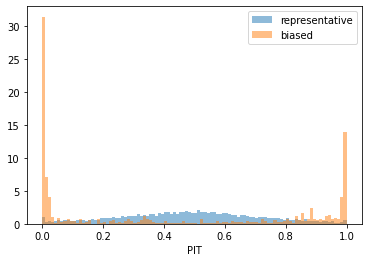

In [44]:
pit_values = cdf_coverage.cdf_coverage(cde_test, y_grid, y_test)
pit_values_bias = cdf_coverage.cdf_coverage(cde_test_bias, y_grid_bias, y_test)

plt.hist(pit_values, alpha=0.5, bins=100, label='representative', density=True)
plt.hist(pit_values_bias, alpha=0.5, bins=100, label='biased', density=True)
# plt.ylim(0, 100)
plt.legend()
plt.xlabel('PIT')

The Highest Predictive Density (HPD) 
\begin{equation}
HPD = \int_{z': p(z' | \vec{d}_{i}, \{z_{n}, \vec{d}_{n}\}_{N}, \pi) \geq p(z | \vec{d}_{i}, \{z_{n}, \vec{d}_{n}\}_{N}, \pi)} p(z' | \vec{d}_{i}, \{z_{n}, \vec{d}_{n}\}_{N}, \pi) dz
\end{equation}
is like the area of the PDF where it exceeds a given value.
Over a population, it would ideally be flat, like the PIT.
[A talk by David Zhao (CMU)](https://drive.google.com/file/d/1uvPtK_RcTUHEwt0ZYld41VKEPHnehWbN/view) has a lovely visualization of the HPD.

Text(0.5, 0, 'HPD')

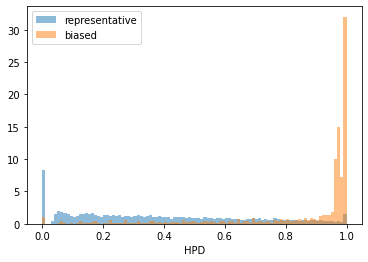

In [45]:
hpd_cov = hpd_coverage.hpd_coverage(cde_test, y_grid, y_test)
hpd_cov_bias = hpd_coverage.hpd_coverage(cde_test_bias, y_grid_bias, y_test)

plt.hist(hpd_cov, alpha=0.5, bins=100, label='representative', density=True)
plt.hist(hpd_cov_bias, alpha=0.5, bins=100, label='biased', density=True)
# plt.ylim(0, 100)
plt.legend()
plt.xlabel('HPD')

The CDE loss 
\begin{equation}
\hat{L} = \frac{1}{K} \sum_{i=1}^{K} \int \left(p(z | \vec{d}_{i}, \{z_{n}, \vec{d}_{n}\}_{N}, \pi)\right)^{2} dz - \frac{2}{K} \sum_{i=1}^{K} p(z_{i} | \vec{d}_{i}, \{z_{n}, \vec{d}_{n}\}_{N}, \pi)
\end{equation}
approximates the true posterior from the estimated posterior evaluated at the true redshift.
It's explained quite well in [a talk by Nic Dalmasso (CMU)](https://www.dropbox.com/s/2r4tl4qv0iyqo9b/STAMPS_LSST_CDE_Tools_Presentation.pdf?dl=0).
A lower value indicates a better estimator.

In [46]:
print(cde_loss.cde_loss(cde_test, y_grid, y_test))
print(cde_loss.cde_loss(cde_test_bias, y_grid_bias, y_test))

(-3.406347034236333, 0.02533246151787181)
(1.6566855153328206, 0.03995796670706558)


### Challenge 3f

The implementations of the PIT, HPD, and CDE Loss above are evaluated on just a subset of the possible combinations of priors (training sets), test set data, and estimator hyperparameters.
Evaluate them on the test cases you considered and compare them to the point estimate metrics.
Do they tell you the same thing or something different?

### Comparison of estimated and true photo-$z$ posterior PDFs

Of course what we really want to know is how well the estimator captures the uncertainty inherent to the photometric data, i.e. how well it approximates the true posterior PDF!
(Although we also want to know how that uncertainty quantification impacts 

`qp` [(Malz, et al 2018)](https://arxiv.org/abs/1806.00014) is a package for manipulating univariate PDFs under many parameterizations and includes a few comparison metrics.
We'll use [the new version of qp](https://github.com/LSSTDESC/qp) for the sake of speed but evaluate metrics using simplified functions ported from [the old version](https://github.com/aimalz/qp) for robustness (because the new qp still has some bugs in checking the normalization of PDFs, oops).

_This content is adapted from the [qp demo](https://github.com/LSSTDESC/qp/blob/master/docs/notebooks/demo.ipynb), written by Alex Malz (CMU), Phil Marshall (SLAC), and Eric Charles (SLAC), and [qp metrics demo](https://github.com/LSSTDESC/qp/blob/master/docs/notebooks/kld.ipynb), written by Alex Malz (CMU) and Phil Marshall (SLAC)._

The first step is to get both the true posteriors and the approximations evaluated on the same grid of redshifts.
Note that some metrics in this category compare approximate and true PDFs as if they are arbitrary functions, whereas others rely on the fact that they are normalized with $p(z | \vec{d}) \eq 0$ and $\int p(z | \vec{d}) dz = 1$.

In [47]:
# P = qp.Ensemble(qp.interp, data=dict(xvals=grid.reshape(grid.shape[0]), yvals=posteriors_test))
Q = qp.Ensemble(qp.interp, data=dict(xvals=y_grid.reshape(y_grid.shape[0]), yvals=cde_test))
Q_bias = qp.Ensemble(qp.interp, data=dict(xvals=y_grid.reshape(y_grid_bias.shape[0]), yvals=cde_test_bias))
grid, approx_pdf_on_grid = Q.gridded(grid)
grid, approx_pdf_on_grid_bias = Q_bias.gridded(grid)

The Kullback Leibler Divergence (KLD)
\begin{equation}
KLD = \int_{-\infty}^{\infty} p(z | \vec{d}) \log\left[\frac{p(z | \vec{d}, \{z_{n}, \vec{d}_{n}\}_{N}, \pi)}{p(z | \vec{d})}\right] dz
\end{equation}
is a directional measure of how much information is lost by using the estimated $p(z | \vec{d}, \{z_{n}, \vec{d}_{n}\}_{N}, \pi)$ instead of the true $p(z | \vec{d})$.
We want the KLD for each galaxy to be low.

[]

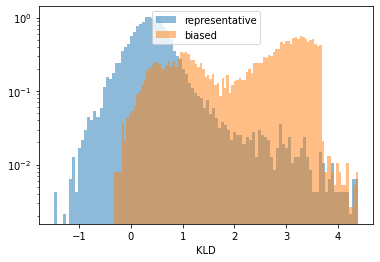

In [48]:
KLDs = np.array([qp.metrics.quick_kld(p, q, dx=np.mean(grid[1:] - grid[:-1])) for p, q in zip(posteriors_test, approx_pdf_on_grid)])
KLDs_bias = np.array([qp.metrics.quick_kld(p, q, dx=np.mean(grid[1:] - grid[:-1])) for p, q in zip(posteriors_test, approx_pdf_on_grid_bias)])

plt.hist(np.log(KLDs), alpha=0.5, bins=100, label='representative', density=True)
plt.hist(np.log(KLDs_bias), alpha=0.5, bins=100, label='biased', density=True)
plt.xlabel('KLD')
plt.legend()
plt.semilogy()

The root-mean-square-error (RMSE) is a symmetric measure commonly used to compare 1D functions.
**TODO: write it out?** Similarly, a lower value corresponds to a more closely approximating posterior PDF.

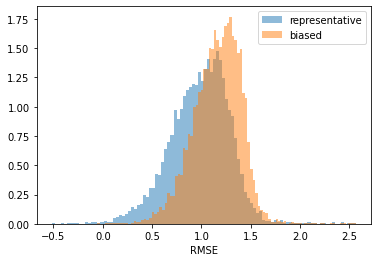

In [49]:
RMSEs = np.array([qp.metrics.quick_rmse(p, q, N=granularity) for p, q in zip(posteriors_test, approx_pdf_on_grid)])
RMSEs_bias = np.array([qp.metrics.quick_rmse(p, q, N=granularity) for p, q in zip(posteriors_test, approx_pdf_on_grid_bias)])

plt.hist(np.log(RMSEs), alpha=0.5, bins=100, label='representative', density=True)
plt.hist(np.log(RMSEs_bias), alpha=0.5, bins=100, label='biased', density=True)
plt.xlabel('RMSE')
plt.legend()

### Challenge 3g

Apply and visualize the local metrics of [Zhao, Dalmasso, Izbicki & Lee, 2021](https://arxiv.org/abs/2102.10473), or any other metrics not included in this demo; the [cde-diagnostics tutorial](https://github.com/zhao-david/CDE-diagnostics/blob/main/tutorial/tutorial-cde-diagnostics.ipynb), written by David Zhao (CMU), may be a good starting point.